In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('..')

In [2]:
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import cuml
import torch
from anndata import AnnData
import seaborn as sns
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from scipy.stats import spearmanr
import torch.nn.functional as F

In [3]:
from pipeline import LoadCytAssistPipeline, IntegrateDatasetPipeline, TrainModelPipeline
from plotting import plot_latent

In [4]:
antibody_panel = pd.read_csv('antibody_panel.csv')
adata_annot = sc.read_h5ad("./adata/tonsil_cytassist.h5ad")
data_path = '/ix/hosmanbeyoglu/kor11/CytAssist/Tonsil'

In [5]:
train_loader = LoadCytAssistPipeline(
    tissue='Tonsil', 
    h5_file=data_path+'/GEX_PEX/filtered_feature_bc_matrix.h5',
    geneset=f'Tonsil.txt',
    sample_id = 0,
    name = 'Tonsil 1',
    celltypes = adata_annot.obs.celltype
)

eval_loader = LoadCytAssistPipeline(
    tissue='Tonsil', 
    h5_file=data_path+'/GEX_PEX_2/filtered_feature_bc_matrix.h5',
    geneset=f'Tonsil.txt',
    sample_id = 1,
    name = 'Tonsil 2',
    celltypes = adata_annot.obs.celltype
)

In [107]:
adata, pdata = train_loader.run()

In [7]:
adata_eval, pdata_eval = eval_loader.run()

In [8]:
adata, adata_eval = IntegrateDatasetPipeline('Tonsil', adata, adata_eval).run()

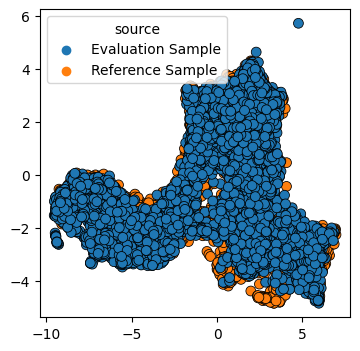

In [9]:
plt.rcParams['figure.figsize'] = [4, 4]
red = cuml.UMAP(
    n_components=2,
    n_neighbors=20,
    min_dist=.1,
)

adatax = AnnData.concatenate(adata, adata_eval, join='inner')

red.fit(adatax.obsm['latent'])
plot_data = red.transform(adatax.obsm['latent'])
sns.scatterplot(plot_data[:, 0], plot_data[:, 1], hue=adatax.obs.source, edgecolor='black', s=50)
plt.show()

In [10]:
trainer = TrainModelPipeline(
    adata = adata,
    pdata = pdata,
    adata_eval =adata_eval,
    pdata_eval = pdata_eval
)

In [11]:
spicess = trainer.run()

torch.Size([4194, 16]) torch.Size([4194, 30]) torch.Size([4908, 16]) torch.Size([4908, 30])


Imputation: 0.681 || Alignment: 0.502% | Loss: 0.00158:  75%|███████▌  | 4126/5500 [08:40<02:53,  7.93it/s, es-counter=200]


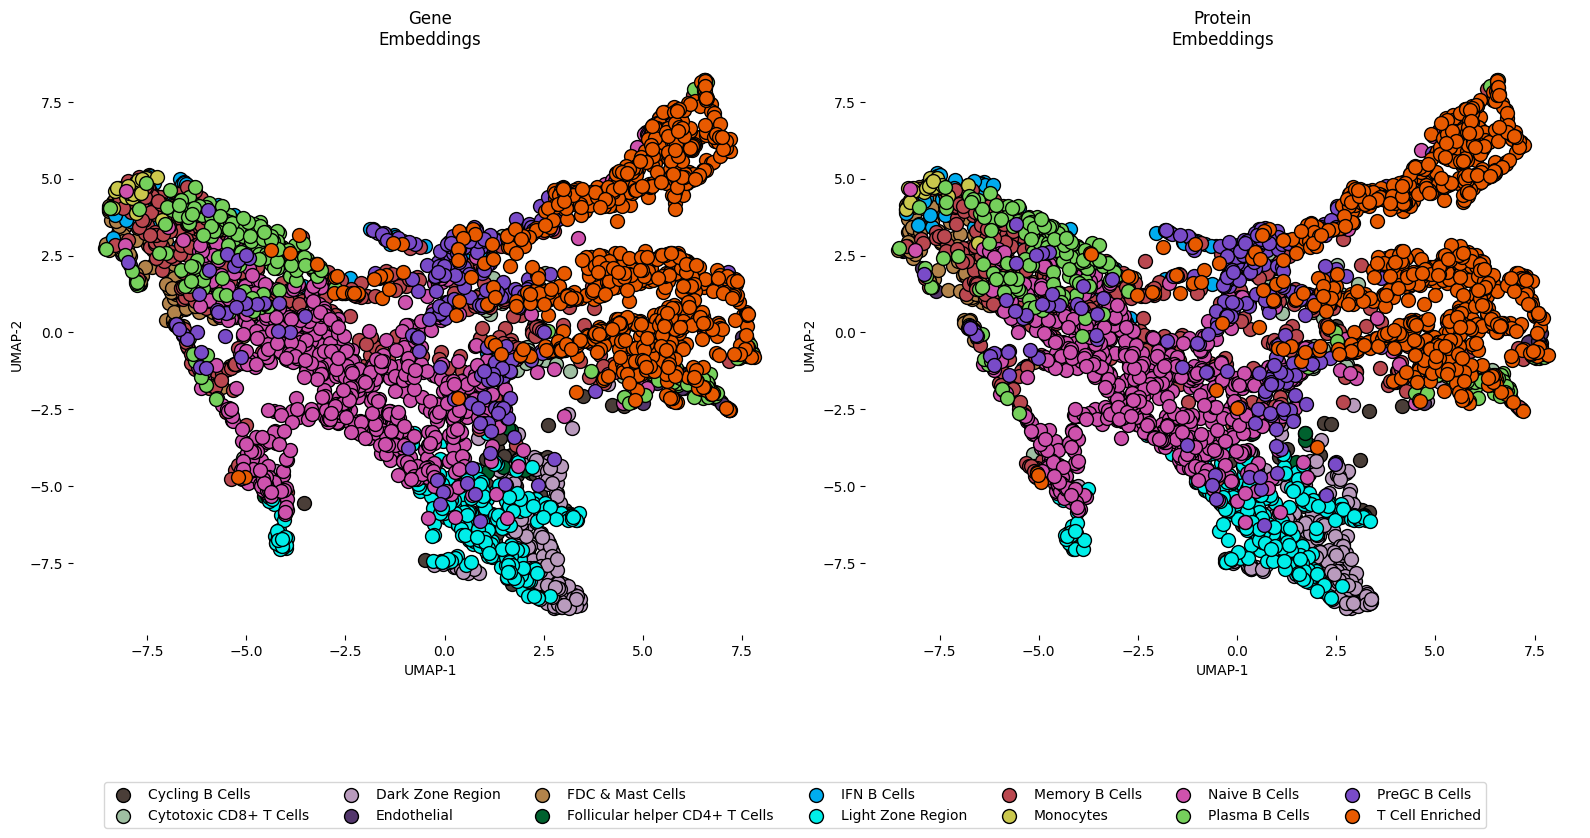

In [12]:
integrated_data =  spicess.model(X=[spicess.d11, spicess.d12], A=spicess.A)
gex_z = integrated_data.gex_z.data.cpu().numpy()
pex_z = integrated_data.pex_z.data.cpu().numpy()
refLabels = adata.obs.celltypes.values
a, b = plot_latent([gex_z, pex_z], [refLabels, refLabels], 
    legend=True, method='umap',
    separate_dim=False, n_neighbors=200,
    # save='./figures/aligned.svg'
);